In [109]:
import pandas as pd

# Carregando o dataset de treino
train_df = pd.read_csv('data/train.csv')

# Definindo as features selecionadas e o target (preço de venda)
features = ['MSZoning', 'LotShape', 'ExterCond', 
            'LotArea', 'YearRemodAdd', 
            'OverallQual', 'OverallCond', 'YrSold',
            'FullBath','HalfBath', 'BsmtFullBath','BsmtHalfBath',
            'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
            'PoolArea','ScreenPorch', 'WoodDeckSF', 'OpenPorchSF']

X_train = train_df[features].dropna()        # subset das colunas de interesse (descarta linhas com NAs nelas)
y_train = train_df.loc[X_train.index, 'SalePrice']  # variável alvo correspondente


In [110]:
import numpy as np
y_train = np.log1p(y_train)

In [111]:

from sklearn.base import BaseEstimator, TransformerMixin

# Engenharia customizada de atributos
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Nenhum ajuste necessário nesta etapa (sem parâmetros aprendidos)
        return self
    
    def transform(self, X):
        # Copiamos X para não alterar o original
        X = X.copy()
        # 1. Tranformação logarítmica da área do lote
        X['LotArea_log'] = np.log1p(X['LotArea'])
        # 2. Anos desde a última reforma até a venda
        X['YearsSinceRemodel'] = X['YrSold'] - X['YearRemodAdd']
        # 3. Interação entre qualidade e condição geral
        X['OverallQualCond'] = X['OverallQual'] * X['OverallCond']

        # Feature: total de banheiros (com meio banheiro contando como 0.5)
        X['TotalBathrooms'] = (
            X['FullBath'] + 0.5 * X['HalfBath'] +
            X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath'])
        
        # Feature: total de área útil (acima + porão)
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']

        # Feature: item de luxo externo (piscina, varanda, deck ou alpendre grande)
        X['LuxoExterno'] = (
            (X['PoolArea'] > 0) |
            (X['ScreenPorch'] > 0) |
            (X['WoodDeckSF'] > 200) |
            (X['OpenPorchSF'] > 100)
        ).astype(int)
        return X


In [112]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Definindo as colunas por tipo
nominal_cols = ['MSZoning']            # categórico nominal
ordinal_cols = ['LotShape', 'ExterCond']  # categóricos ordinais
numeric_cols = ['LotArea_log', 'YearsSinceRemodel', 'OverallQualCond', 'YrSold', 'TotalBathrooms', 'TotalSF', 'LuxoExterno']  # numéricos (inclui features criadas)

# Pipeline para variáveis nominais
nominal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),  # preenche categoria Missing
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Pipeline para variáveis ordinais

ordinal_mapping = [
    ['IR3', 'IR2', 'IR1', 'Reg'],           # LotShape
    ['Po', 'Fa', 'TA', 'Gd', 'Ex']          # ExterCond
]
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ord', OrdinalEncoder(categories=ordinal_mapping))
])

# Pipeline para variáveis numéricas
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # preenche NaN com mediana
    ('scaler', StandardScaler())                   # padroniza (média=0, dp=1)
])

# Combinando tudo em um transformador de colunas
preprocessor = ColumnTransformer(transformers=[
    ('nom', nominal_pipeline, nominal_cols),
    ('ord', ordinal_pipeline, ordinal_cols),
    ('num', numeric_pipeline, numeric_cols)
    # (colunas não especificadas serão descartadas automaticamente)
])


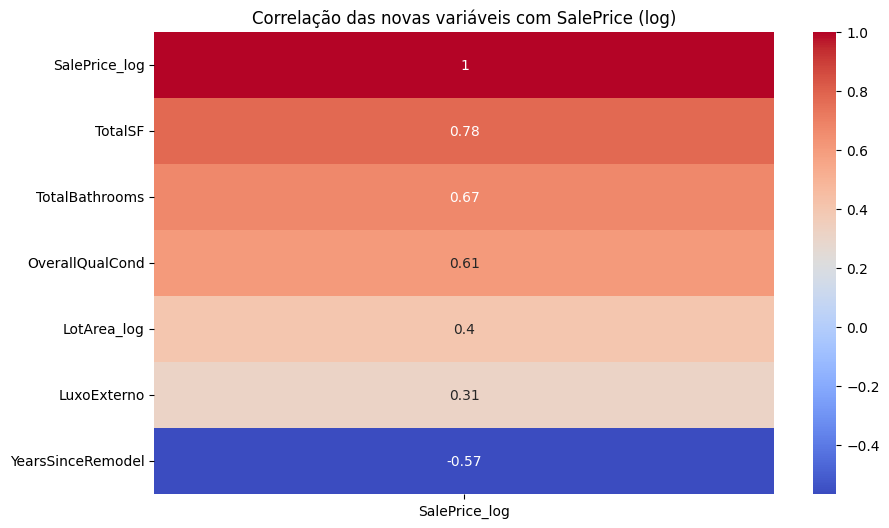

In [113]:
# Aplicando o transform manualmente (sem pipeline)
fe = FeatureEngineer()
df_engineered = fe.transform(train_df.copy())

# SalePrice em log
df_engineered['SalePrice_log'] = np.log1p(train_df['SalePrice'])

# Correlação com SalePrice_log
correlacoes = df_engineered[[
    'LotArea_log',
    'YearsSinceRemodel',
    'OverallQualCond',
    'TotalBathrooms',
    'TotalSF',
    'LuxoExterno',
    'SalePrice_log'
]].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(correlacoes[['SalePrice_log']].sort_values(by='SalePrice_log', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlação das novas variáveis com SalePrice (log)")
plt.show()


In [114]:
# Pipeline completo: 1) engenharia de features, 2) pré-processamento (encoders, escala)
full_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineer()),
    ('preprocessing', preprocessor)
])


In [115]:
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-3, 3, 50)  # de 0.001 a 1000, em escala log, 50 valores
# Pipeline do modelo Ridge, incluindo a engenharia de features antes do preprocessor
ridge_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineer()),
    ('preprocessing', preprocessor),
    ('model', RidgeCV(alphas=alphas, scoring='neg_root_mean_squared_error', cv=5))
])

In [116]:
ridge_pipeline.fit(X_train, y_train)


Pipeline(steps=[('feature_engineering', FeatureEngineer()),
                ('preprocessing',
                 ColumnTransformer(transformers=[('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['MSZoning']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_val...
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03]),
                         cv=5, scoring='neg_root_mean_squared_error'))])

In [117]:
from sklearn.model_selection import cross_val_score

# Avaliação com validação cruzada (5-fold CV) usando RMSE
scores = cross_val_score(ridge_pipeline, X_train, y_train, 
                         scoring='neg_root_mean_squared_error', cv=5)

rmse_scores = -scores  # torna positivos os RMSEs (já que eram negativos)
print(f"RMSE médio (CV 5 folds): {rmse_scores.mean():.2f}")
print(f"Desvio padrão do RMSE: {rmse_scores.std():.2f}")


RMSE médio (CV 5 folds): 0.18
Desvio padrão do RMSE: 0.03


In [118]:
X_transformed = ridge_pipeline.named_steps['preprocessing'].transform(
    ridge_pipeline.named_steps['feature_engineering'].transform(X_train)
)


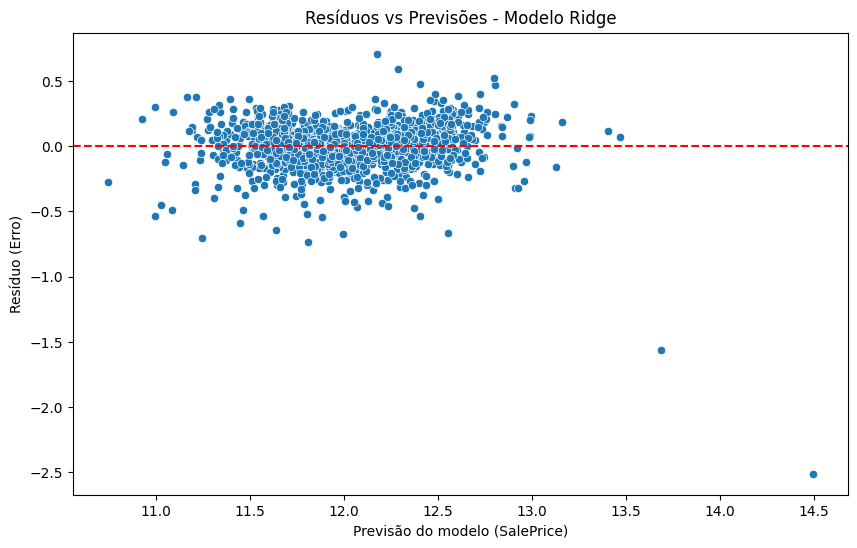

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = ridge_pipeline.predict(X_train)
residuals = y_train - y_pred

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Previsão do modelo (SalePrice)")
plt.ylabel("Resíduo (Erro)")
plt.title("Resíduos vs Previsões - Modelo Ridge")
plt.show()


Bias (viés)	Baixo — resíduos centralizados em 0 ✅  
Heterocedasticidade	Leve — maior variância para valores extremos ⚠️  
Não-linearidade aparente	Pouca ou nenhuma curvatura evidente ✅  
Possíveis melhorias	Explorar modelos que lidem melhor com outliers ou heterocedasticidade: Tree-based, Gradient Boosting, etc.  

In [133]:
from sklearn.ensemble import RandomForestRegressor

# Pipeline com Random Forest
rf_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineer()),
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])


In [134]:
from sklearn.model_selection import GridSearchCV

# Espaço de busca para n_estimators
param_grid = {
    'model__n_estimators': [180, 200, 220, 240, 260],
    'model__max_depth': [8, 10, 12]
}

# Grid Search com validação cruzada (5-fold)
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
print(f"Melhor número de árvores: {grid_search.best_params_['model__n_estimators']}")
print(f"Melhor RMSE (negativo): {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Melhor número de árvores: 220
Melhor RMSE (negativo): -0.1536


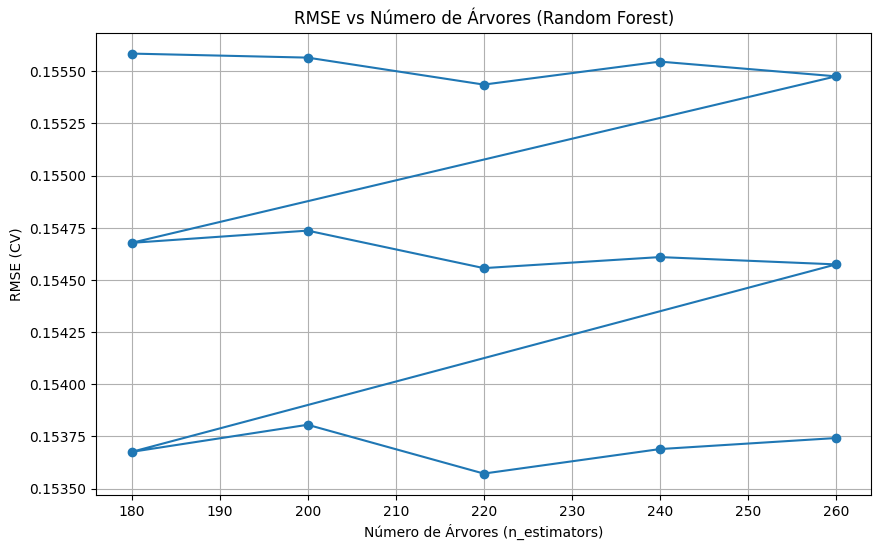

In [135]:
results = grid_search.cv_results_
estimators = results['param_model__n_estimators']
mean_scores = -results['mean_test_score']  # Tornar RMSE positivo

plt.figure(figsize=(10,6))
plt.plot(estimators, mean_scores, marker='o')
plt.xlabel('Número de Árvores (n_estimators)')
plt.ylabel('RMSE (CV)')
plt.title('RMSE vs Número de Árvores (Random Forest)')
plt.grid()
plt.show()


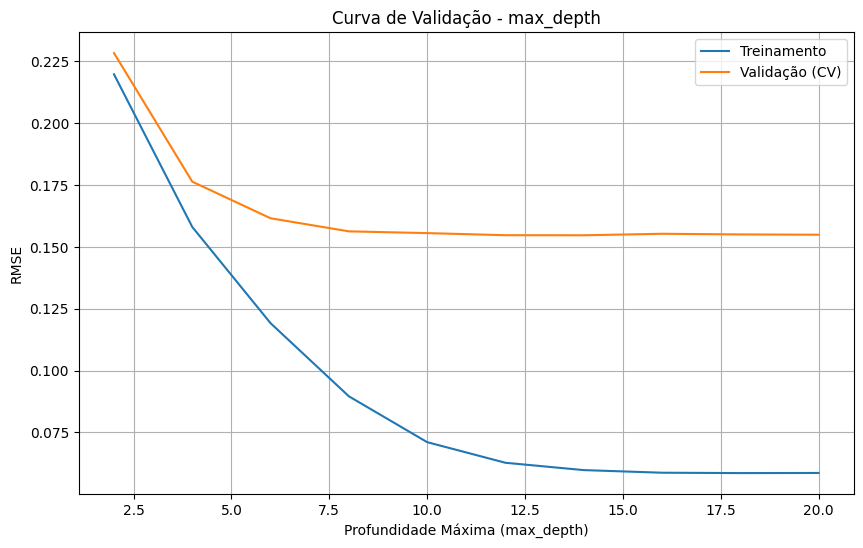

In [136]:
from sklearn.model_selection import validation_curve

# Avaliando o impacto da profundidade máxima das árvores
depth_range = np.arange(2, 21, 2)

train_scores, val_scores = validation_curve(
    rf_pipeline,
    X=X_train,
    y=y_train,
    param_name='model__max_depth',
    param_range=depth_range,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Convertendo para RMSE positivo
train_rmse = -train_scores.mean(axis=1)
val_rmse = -val_scores.mean(axis=1)

plt.figure(figsize=(10,6))
plt.plot(depth_range, train_rmse, label='Treinamento')
plt.plot(depth_range, val_rmse, label='Validação (CV)')
plt.xlabel('Profundidade Máxima (max_depth)')
plt.ylabel('RMSE')
plt.title('Curva de Validação - max_depth')
plt.legend()
plt.grid()
plt.show()


In [137]:
# Usando o modelo ajustado encontrado pelo GridSearchCV
best_model = grid_search.best_estimator_

# Previsão em escala logarítmica
y_pred_log = best_model.predict(X_train)

# Convertendo de log1p de volta para escala real
y_real = np.expm1(y_train)
y_pred_real = np.expm1(y_pred_log)

# Calculando os erros
errors = y_real - y_pred_real
abs_errors = np.abs(errors)
rel_errors = abs_errors / y_real

# Verificando rapidamente
print(f"Erro absoluto médio: {abs_errors.mean():,.2f}")
print(f"Erro percentual médio: {rel_errors.mean():.2%}")

Erro absoluto médio: 8,115.09
Erro percentual médio: 4.57%


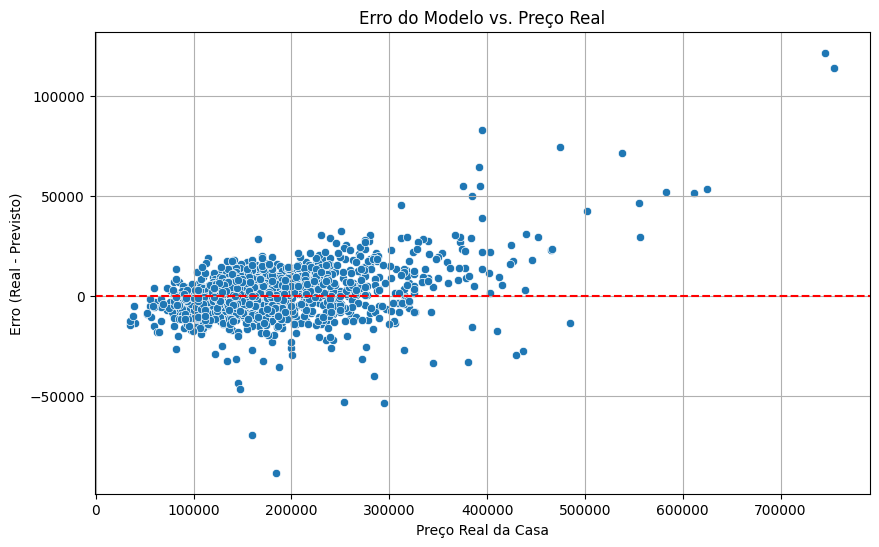

In [138]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_real, y=errors)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Preço Real da Casa")
plt.ylabel("Erro (Real - Previsto)")
plt.title("Erro do Modelo vs. Preço Real")
plt.grid()
plt.show()


Temos um problema de heterocedasticidade, conforme podemos observar no gráfico acima, conforme o valor da casa aumenta nosso erro também.  
Faz sentido, baseado em como configuramos nosso randomforeast e como ele foca na média.  

In [144]:

# 1. Carregar o conjunto de teste (usando a mesma lógica do treino)
test_df = pd.read_csv('data/test.csv')  # substitua pelo path correto se estiver diferente

# 2. Garantir que as colunas necessárias estão presentes (verificação opcional)
# print(set(X_train.columns) - set(test_df.columns))

# 3. Aplicar o pipeline no conjunto de teste
final_model = grid_search.best_estimator_
SalePrice_log = final_model.predict(test_df)
# Converte log para preço real
SalePrice = np.expm1(SalePrice_log)

# 4. Gerar DataFrame com o formato solicitado pelo Kaggle
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': SalePrice
})

# 6. Salvar em CSV
submission.to_csv('submission.csv', index=False)



c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
